This is a notebook that computes and scans model C.
It uses a evenly spaced grid

# Init

In [3]:
from __future__ import division

In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import sys
sys.path.insert(0, '/a/home/cc/students/physics/chensun/Code/BEC_dynamics/python_code_v2/')


In [6]:
import numpy as np
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
from scipy.integrate import quad
import h5py
import glob
import re
import os

import scan
import pickle
import glob
from multiprocessing import Pool
from contextlib import closing

from matplotlib import cm

In [7]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import spc
import model
import chi2
import margin

In [8]:
path = '../data/SPARC.txt'
data = spc.readSPARC(path)

path = '../data/SPARC_Lelli2016c.txt'
spc.readSPARC_ext(data, path)

# Scan on one galaxy, a demo

In [9]:
ups_low = 0.
ups_high = 5.
log_M_low = 5.
log_M_high = 11.
log_m_low = -24
log_m_high = -19

ups_disk_arr = np.linspace(ups_low, ups_high, 20)
ups_bulg_arr = np.linspace(ups_low, ups_high, 20)
log_M_arr = np.linspace(log_M_low, log_M_high, 30)
log_m_arr = np.linspace(log_m_low, log_m_high, 20)

ups_disk_mesh, ups_bulg_mesh = np.meshgrid(ups_disk_arr, ups_bulg_arr)

ups_disk_flat = ups_disk_mesh.reshape(-1)
ups_bulg_flat = ups_bulg_mesh.reshape(-1) 
#log_M_flat = log_M_mesh.reshape(-1)

In [10]:
gal = spc.findGalaxyByName('UGC01281', data)
gal.name

'UGC01281'

In [11]:
res_arr = []
for log_m in log_m_arr:
    
    m = 10**log_m
    chi2_arr = np.asarray([1e10]*len(log_M_arr))

    # for each M value, minimizes over Ups
    for j in range(len(log_M_arr)):
        M = 10**log_M_arr[j]
        for i in range(len(ups_disk_flat)):
            ups_disk = ups_disk_flat[i]
            ups_bulg = ups_bulg_flat[i]
            chi2_val = chi2.chi2_single_gal_overshooting(m=m, M=M, ups_disk=ups_disk, ups_bulg=ups_bulg, gal=gal)
            chi2_arr[j] = min(chi2_arr[j], chi2_val)
            
    result = scan.Result(log_m)
    result.chi2_arr = chi2_arr
    result.M_arr = 10**log_M_arr
    
    # sanity check
    result.check_chi_min()
    
    # save it
    res_arr.append(result)
    

<IPython.core.display.Javascript object>


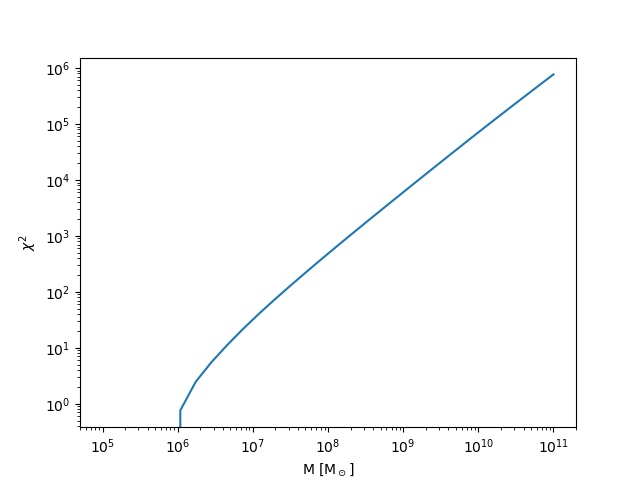

Text(0,0.5,'$\\chi^2$')

In [12]:
plt.subplots()
plt.plot(10**log_M_arr, chi2_arr)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('M [M$_\odot$]')
plt.ylabel('$\chi^2$')

In [13]:
scan.analyze(res_arr, [1,2,3,4,5,10])

<IPython.core.display.Javascript object>


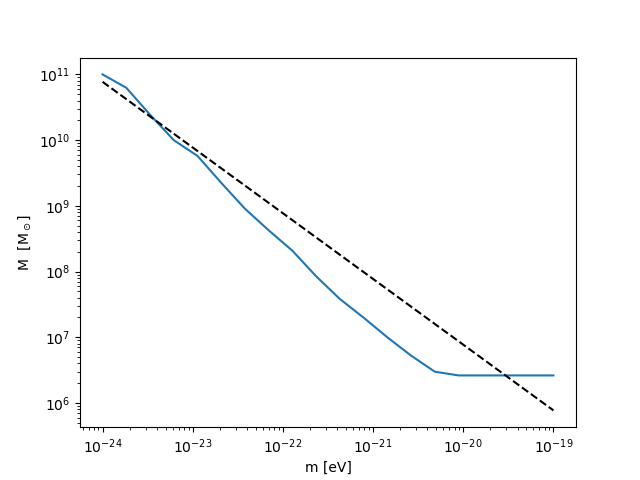

Text(0,0.5,'M  [M$_\\odot$]')

In [15]:
plt.subplots()

m_plt_arr = []
M_plt_arr = []
for result in res_arr:
    m = result.m
    M = result.M_contours[4]
    m_plt_arr.append(m)
    M_plt_arr.append(M)

# the bound
plt.plot(m_plt_arr, M_plt_arr)
# the SH prediction
Msol_SH_arr = model.M_SH(m_plt_arr, gal)
plt.plot(m_plt_arr, Msol_SH_arr, 'k--')

plt.yscale('log')
plt.xscale('log')
plt.xlabel('m [eV]')
plt.ylabel('M  [M$_\odot$]')

<IPython.core.display.Javascript object>


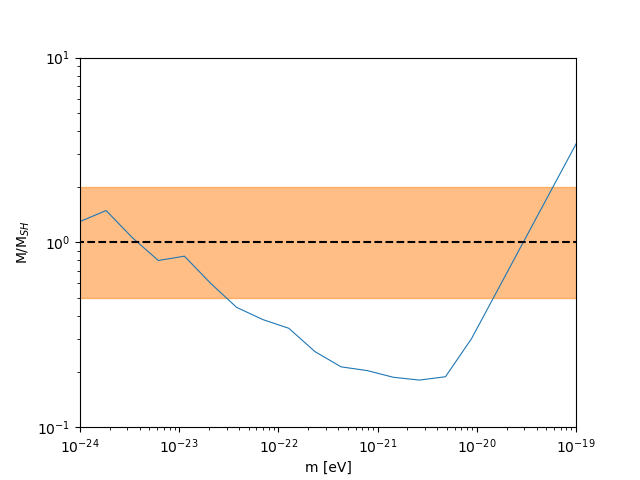

(1e-24, 1e-19)

In [16]:
# ratio plot

plt.subplots()

m_plt_arr = []
M_plt_arr = []
for result in res_arr:
    m = result.m
    M = result.M_contours[4]
    m_plt_arr.append(m)
    M_plt_arr.append(M)

# the bound
Msol_SH_arr = model.M_SH(m_plt_arr, gal)
plt.plot(m_plt_arr, M_plt_arr/ Msol_SH_arr, lw='0.8')

# the SH prediction
x = np.logspace(-25, -18)
y = [1] * 50
ylow = [0.5] * 50
yup = [2] * 50
plt.fill_between(x, ylow, yup, alpha=0.5, color='C1')
plt.plot(x, y, 'k--')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('m [eV]')
plt.ylabel('M/M$_{SH}$')
plt.ylim(0.1, 10)
plt.xlim(1e-24, 1e-19)

In [64]:
# save instance to file
uid = np.random.randint(1e10)
path = '../results/result-%d.dat' %uid

with open(path, 'w') as f:
    pickle.dump(result, f)

##load with
# with open(path, 'r') as f:
#     result2 = pickle.load(f)

# Scan on one galaxy - with scan.py

In [17]:
# packaged everything into scan.scan() 
scanner = scan.Scanner()
scanner.scan(gal, 
          num_of_ups=20, 
          num_of_log_M=20, 
          num_of_log_m=5, 
          dir_name='results_test3')

100%|██████████| 5/5 [00:25<00:00,  5.14s/it]


In [ ]:
# load and plot out

<IPython.core.display.Javascript object>


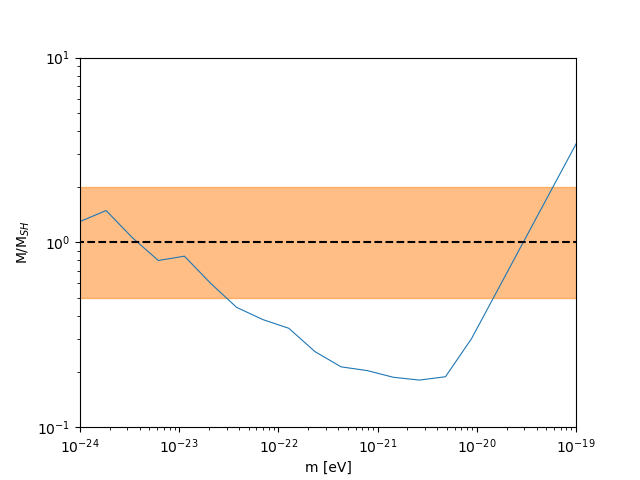

In [20]:
plt.subplots()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('m [eV]')
plt.ylabel('M/M$_{SH}$')
plt.ylim(0.1, 10)
plt.xlim(1e-24, 1e-19)

path_wild = '../results_test3/*'
path_arr = glob.glob(path_wild)
for path in path_arr:
    with open(path, 'r') as f:
        result= pickle.load(f)      
        m_plt_arr = []
        M_plt_arr = []
        for result in res_arr:
            m = result.m
            M = result.M_contours[4]
            m_plt_arr.append(m)
            M_plt_arr.append(M)

        # the bound
        Msol_SH_arr = model.M_SH(m_plt_arr, gal)
        plt.plot(m_plt_arr, M_plt_arr/ Msol_SH_arr, lw='0.8')

        # the SH prediction
        x = np.logspace(-25, -18)
        y = [1] * 50
        ylow = [0.5] * 50
        yup = [2] * 50
        plt.fill_between(x, ylow, yup, alpha=0.5, color='C1')
        plt.plot(x, y, 'k--')


# Scan on all SPARC - from scan.py

In [9]:
scanner = scan.Scanner()

def f(gal):
    scanner.scan(gal, 
                 num_of_ups=50, #20
                 num_of_log_M=50, #20
                 num_of_log_m=50, #20
                 dir_name='results_test8')

with closing(Pool()) as pool:
    pool.map(f, data)
    pool.terminate()


100%|██████████| 50/50 [6:36:08<00:00, 475.36s/it]  


In [7]:
bound_dct = {}

<IPython.core.display.Javascript object>


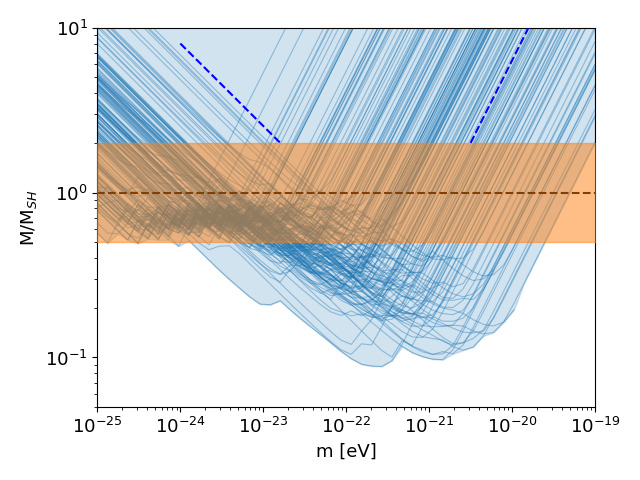

In [30]:
plt.subplots()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('m [eV]')
plt.ylabel('M/M$_{SH}$')
plt.ylim(0.05, 10)
#plt.xlim(2e-24, 1e-19)
plt.xlim(1e-25, 1e-19)

ratio_upper = 2
ratio_lower = 0.5

M_joint_arr = []
m_joint_arr = []
n_ind = 1

path_wild = '../results_test10/*'
path_arr = glob.glob(path_wild)
for path in path_arr:
    with open(path, 'r') as f:
        results= pickle.load(f)      
        res_arr = results.storage
        
        m_plt_arr = []
        M_plt_arr = []
        for result in res_arr:
            if not result.sane:
                continue            
            m = result.m
            M = result.M_contours[n_ind]
            m_plt_arr.append(m)
            M_plt_arr.append(M)
        
        # the bound
        m_plt_arr = np.asarray(m_plt_arr)        
        Msol_SH_arr = model.M_SH(m_plt_arr, result.gal)
        ratio_arr = M_plt_arr/ Msol_SH_arr
        mask = ratio_arr < ratio_upper * 10
        plt.plot(m_plt_arr[mask], ratio_arr[mask], lw='0.8', color='C0', alpha=0.4)
        
        m_joint_arr, M_joint_arr = scan.lower_array(m_joint_arr, M_joint_arr, m_plt_arr, ratio_arr)

# the joint bound
plt.fill_between(m_plt_arr, M_joint_arr, 10, color='C0', alpha=0.2)
bound_dct[str(n_ind)] = (m_plt_arr, M_joint_arr)

# the SH prediction
x = np.logspace(-25, -18)
y = [1] * 50
ylow = [ratio_lower] * 50
yup = [ratio_upper] * 50
plt.fill_between(x, ylow, yup, alpha=0.5, color='C1', zorder=3)
plt.plot(x, y, 'k--')

m_test = np.logspace(-24, -22.8)
M_test = 8*(m_test/1e-24)**(-1/2)
plt.plot(m_test, M_test, 'b--', zorder=5)

m_test = np.logspace(-20.5, -19)
M_test = 2.*(m_test/m_test[0])
plt.plot(m_test, M_test, 'b--', zorder=5)

plt.rcParams.update({'font.size': 13})
plt.tight_layout()

#plt.savefig('./sol_full_SPARC_2sigma.pdf')

<IPython.core.display.Javascript object>


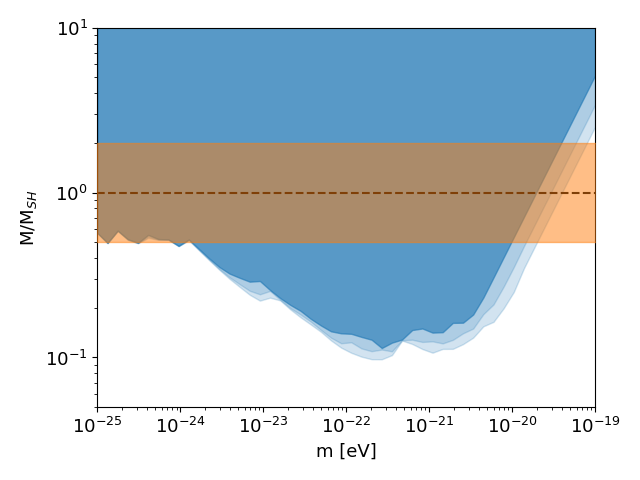

In [29]:
plt.subplots()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('m [eV]')
plt.ylabel('M/M$_{SH}$')
plt.ylim(0.05, 10)
plt.xlim(1e-25, 1e-19)

(m, Mratio) = bound_dct['2']
plt.fill_between(m, Mratio, 10, alpha=0.2, color='C0')

(m, Mratio) = bound_dct['4']
plt.fill_between(m, Mratio, 10, alpha=0.2, color='C0')

(m, Mratio) = bound_dct['5']
plt.fill_between(m, Mratio, 10, alpha=0.6, color='C0')


# the SH prediction
x = np.logspace(-25, -18)
y = [1] * 50
ylow = [ratio_lower] * 50
yup = [ratio_upper] * 50
plt.fill_between(x, ylow, yup, alpha=0.5, color='C1', zorder=3)
plt.plot(x, y, 'k--')

plt.rcParams.update({'font.size': 13})
plt.tight_layout()

#plt.savefig('./sol_full_SPARC_combine.pdf')

<IPython.core.display.Javascript object>


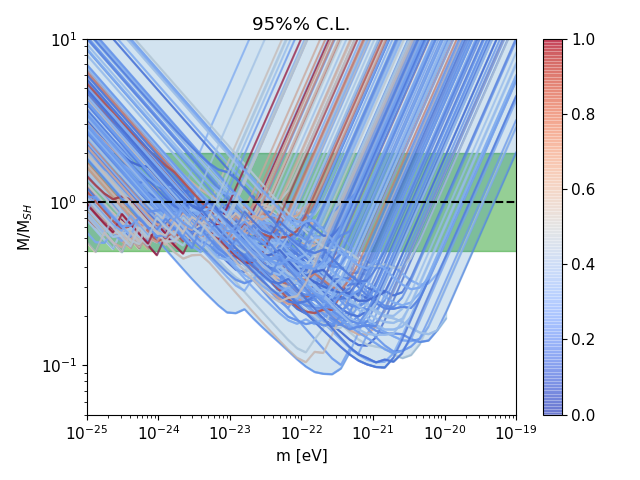

In [33]:
_, ax = plt.subplots()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('m [eV]')
plt.ylabel('M/M$_{SH}$')
plt.ylim(0.05, 10)
plt.xlim(1e-25, 1e-19)

ratio_upper = 2
ratio_lower = 0.5
f_cut = 1

M_joint_arr = []
m_joint_arr = []
n_ind = 1

path_wild = '../results_test10/*'
path_arr = glob.glob(path_wild)
for path in path_arr:
    with open(path, 'r') as f:
        results= pickle.load(f)      
        res_arr = results.storage
        
        m_plt_arr = []
        M_plt_arr = []
        for result in res_arr:
            if not result.sane:
                continue            
            m = result.m
            M = result.M_contours[n_ind]
            m_plt_arr.append(m)
            M_plt_arr.append(M)
        
        # the bound
        m_plt_arr = np.asarray(m_plt_arr)        
        Msol_SH_arr = model.M_SH(m_plt_arr, result.gal)
        ratio_arr = M_plt_arr/ Msol_SH_arr
        mask = ratio_arr < ratio_upper * 10
        m_plt_finer_arr = np.logspace(np.log10(m_plt_arr[0]), np.log10(m_plt_arr[-1]), 1000)
        ratio_finer_arr = np.exp(np.interp(np.log(m_plt_finer_arr), 
                                           np.log(m_plt_arr), 
                                           np.log(ratio_arr)))
        M_plt_finer_arr = np.exp(np.interp(np.log(m_plt_finer_arr), 
                                           np.log(m_plt_arr), 
                                           np.log(M_plt_arr)))        
        fbar2DM =[]
        for i, mm in enumerate(m_plt_finer_arr):
            MMsol = M_plt_finer_arr[i]
            val = model.bar_ratio_at_peak(result.gal, MMsol)            
            val = min(val, 1)
            fbar2DM.append(val)
            if val > f_cut:
                ratio_finer_arr[i] = 100
        fbar2DM[0] = 0
        fbar2DM[1] = 1
        sc = plt.scatter(m_plt_finer_arr, ratio_finer_arr, s=0.4, c=(fbar2DM), cmap=cm.coolwarm, alpha=0.5)               
        m_joint_arr, M_joint_arr = scan.lower_array(m_joint_arr, M_joint_arr, m_plt_finer_arr, ratio_finer_arr)

        
plt.colorbar(sc)

# the joint bound
plt.fill_between(m_joint_arr, M_joint_arr, 10, color='C0', alpha=0.2)
bound_dct[str(n_ind)] = (m_plt_arr, M_joint_arr)

# the SH prediction
x = np.logspace(-25, -18)
y = [1] * 50
ylow = [ratio_lower] * 50
yup = [ratio_upper] * 50
plt.fill_between(x, ylow, yup, alpha=0.5, color='C2', zorder=0)
plt.plot(x, y, 'k--')
plt.title('95%% C.L.')

plt.rcParams.update({'font.size': 11})
plt.tight_layout()

#plt.savefig('./sol_full_SPARC_2sigma_cmap.pdf')